# Design an application related to public health (Analysis Part)

The "Public Health France" agency has launched a call for projects to find innovative ideas for food-related applications. You wish to participate and propose an application idea.

The Open Food Fact dataset is available on the official website. The variables are defined at this address.

The dataset has as datapoint each product (1443749 products) and for each couple we have 181 columns which are separated in four sections :

- General information on the product datasheet: name, date of modification, etc.
- A set of tags: product category, location, origin, etc.
- The ingredients that make up the products and their possible additives.
- Nutritional information: quantity in grams of a nutrient per 100 grams of the product.
- The goal of the project is to understand this dataset, to draw some insights and finally to train a model able to predict the nutriscore for each product in the way of the Yuka application.

How is the nutriscore awarded?

The score takes into account for 100 grams of product, the content :

- Nutrients and foods to be promoted (fibers, proteins, fruits and vegetables),
- Nutrients to be limited (energy, saturated fatty acids, sugars, salt).
- After calculation, the score obtained by a product is used to assign it a letter (A to D) and a color.


In [60]:
import json
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

plt.style.use('ggplot')
from matplotlib.pyplot import figure
%matplotlib inline
pd.options.mode.chained_assignment = None

## 1. Data Import

In [61]:
df = pd.read_csv('openfoodfacts_products_cleaned.csv', low_memory=False)

## 2. Data Description
##### Show data header


In [62]:
df.head(3)

,code,product_name,main_category_en,pnns_groups_1,pnns_groups_2,nutriscore_score,nutriscore_grade,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
0,0000000000017,vitória crackers,NaN,unknown,unknown,NaN,NaN,1569.0,7.0,3.08,70.1,15.0,0.0,7.8,1.40
1,0000000000100,moutarde au moût de raisin,Mustards,Fat and sauces,Dressings and sauces,18.0,d,936.0,8.2,2.20,29.0,22.0,0.0,5.1,4.60
2,0000000000123,sauce sweety chili 0%,NaN,unknown,unknown,NaN,NaN,88.0,0.0,0.00,4.8,0.4,0.0,0.2,2.04


##### Show data info


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045457 entries, 0 to 1045456
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   code                1045457 non-null  object 
 1   product_name        1045455 non-null  object 
 2   main_category_en    593670 non-null   object 
 3   pnns_groups_1       1043571 non-null  object 
 4   pnns_groups_2       1045457 non-null  object 
 5   nutriscore_score    536478 non-null   float64
 6   nutriscore_grade    536478 non-null   object 
 7   energy_100g         1044885 non-null  float64
 8   fat_100g            1042722 non-null  float64
 9   saturated-fat_100g  1014514 non-null  float64
 10  carbohydrates_100g  1042626 non-null  float64
 11  sugars_100g         1036956 non-null  float64
 12  fiber_100g          1045457 non-null  float64
 13  proteins_100g       1044779 non-null  float64
 14  salt_100g           1043815 non-null  float64
dtypes: float64(9), 

##### Fix data types


In [64]:
df.product_name = df.product_name.astype('category')
df.main_category_en = df.main_category_en.astype('category')
df.pnns_groups_1 = df.pnns_groups_1.astype('category')
df.pnns_groups_2 = df.pnns_groups_2.astype('category')
df.nutriscore_grade = df.nutriscore_grade.astype('category')

Now, let's check our new data types and column names:

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045457 entries, 0 to 1045456
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   code                1045457 non-null  object  
 1   product_name        1045455 non-null  category
 2   main_category_en    593670 non-null   category
 3   pnns_groups_1       1043571 non-null  category
 4   pnns_groups_2       1045457 non-null  category
 5   nutriscore_score    536478 non-null   float64 
 6   nutriscore_grade    536478 non-null   category
 7   energy_100g         1044885 non-null  float64 
 8   fat_100g            1042722 non-null  float64 
 9   saturated-fat_100g  1014514 non-null  float64 
 10  carbohydrates_100g  1042626 non-null  float64 
 11  sugars_100g         1036956 non-null  float64 
 12  fiber_100g          1045457 non-null  float64 
 13  proteins_100g       1044779 non-null  float64 
 14  salt_100g           1043815 non-null  float64 
dty

##### Show statistical analysis of our data set
Let's show min, max, mean, std, and count of each column in the dataset.

In [66]:
df.describe()

,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,536478.000000,1.044885e+06,1.042722e+06,1.014514e+06,1.042626e+06,1.036956e+06,1.045457e+06,1.044779e+06,1.043815e+06
mean,8.973164,1.095151e+03,1.264644e+01,4.983637e+00,2.742256e+01,1.327794e+01,8.781615e-01,8.500612e+00,1.219405e+00
std,8.908539,7.478307e+02,1.565022e+01,7.302543e+00,2.746102e+01,1.918074e+01,2.549140e+00,9.633584e+00,3.845868e+00
min,-15.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,4.230000e+02,7.000000e-01,1.000000e-01,3.570000e+00,7.000000e-01,0.000000e+00,1.400000e+00,8.000000e-02
50%,10.000000,1.046000e+03,6.700000e+00,1.800000e+00,1.462000e+01,3.700000e+00,0.000000e+00,5.810000e+00,5.750000e-01
75%,16.000000,1.632000e+03,2.000000e+01,7.000000e+00,5.200000e+01,1.846000e+01,1.000000e-01,1.200000e+01,1.392500e+00
max,40.000000,3.700000e+03,9.997000e+01,9.990000e+01,9.999000e+01,1.000000e+02,9.550000e+01,9.990000e+01,9.999000e+01


##### Show if there are missing datapoints¶


In [67]:
obj = df.isna().mean().round(4) * 100
for key,value in obj.iteritems():
    print(key,",",value)

code , 0.0
product_name , 0.0
main_category_en , 43.21
pnns_groups_1 , 0.18
pnns_groups_2 , 0.0
nutriscore_score , 48.68
nutriscore_grade , 48.68
energy_100g , 0.05
fat_100g , 0.26
saturated-fat_100g , 2.96
carbohydrates_100g , 0.27
sugars_100g , 0.8099999999999999
fiber_100g , 0.0
proteins_100g , 0.06
salt_100g , 0.16


[Text(33.0, 0.5, 'Data Points'),
 Text(0.5, 14.09375, 'Columns'),
 Text(0.5, 1, 'Missing Data')]

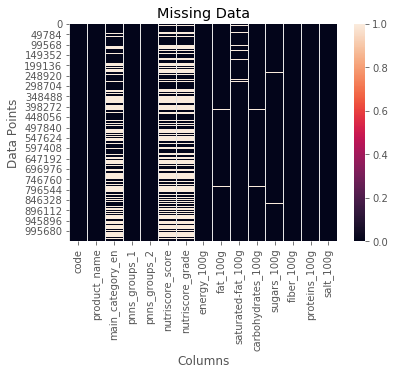

In [9]:
sns.heatmap(df.isnull()).set(title = 'Missing Data', xlabel = 'Columns', ylabel = 'Data Points')

We can see from above that we have some missing data points, but it is not extensive and it mainly concerns the categorical features.

Later in the project we will deal with these missing data points, in the data cleaning section.

In [68]:
df['energy_100g'] = df['energy_100g'].fillna(df.groupby(['pnns_groups_1'])['energy_100g'].transform('mean'))

df['fat_100g'] = df['fat_100g'].fillna(df.groupby(['pnns_groups_1'])['fat_100g'].transform('mean'))

df['saturated-fat_100g'] = df['saturated-fat_100g'].fillna(df.groupby(['pnns_groups_1'])['saturated-fat_100g'].transform('mean'))

df['carbohydrates_100g'] = df['carbohydrates_100g'].fillna(df.groupby(['pnns_groups_1'])['carbohydrates_100g'].transform('mean'))

df['sugars_100g'] = df['sugars_100g'].fillna(df.groupby(['pnns_groups_1'])['sugars_100g'].transform('mean'))

df['proteins_100g'] = df['proteins_100g'].fillna(df.groupby(['pnns_groups_1'])['proteins_100g'].transform('mean'))

df['salt_100g'] = df['salt_100g'].fillna(df.groupby(['pnns_groups_1'])['salt_100g'].transform('mean'))



In [69]:
df = df.dropna(how='any', subset=['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g'])

In [70]:
obj = df.isna().mean().round(4) * 100
for key,value in obj.iteritems():
    print(key,",",value)

code , 0.0
product_name , 0.0
main_category_en , 43.22
pnns_groups_1 , 0.16
pnns_groups_2 , 0.0
nutriscore_score , 48.67
nutriscore_grade , 48.67
energy_100g , 0.0
fat_100g , 0.0
saturated-fat_100g , 0.0
carbohydrates_100g , 0.0
sugars_100g , 0.0
fiber_100g , 0.0
proteins_100g , 0.0
salt_100g , 0.0


## 2. EDA
### 2.1 Univariate Analysis: Numerical Variable

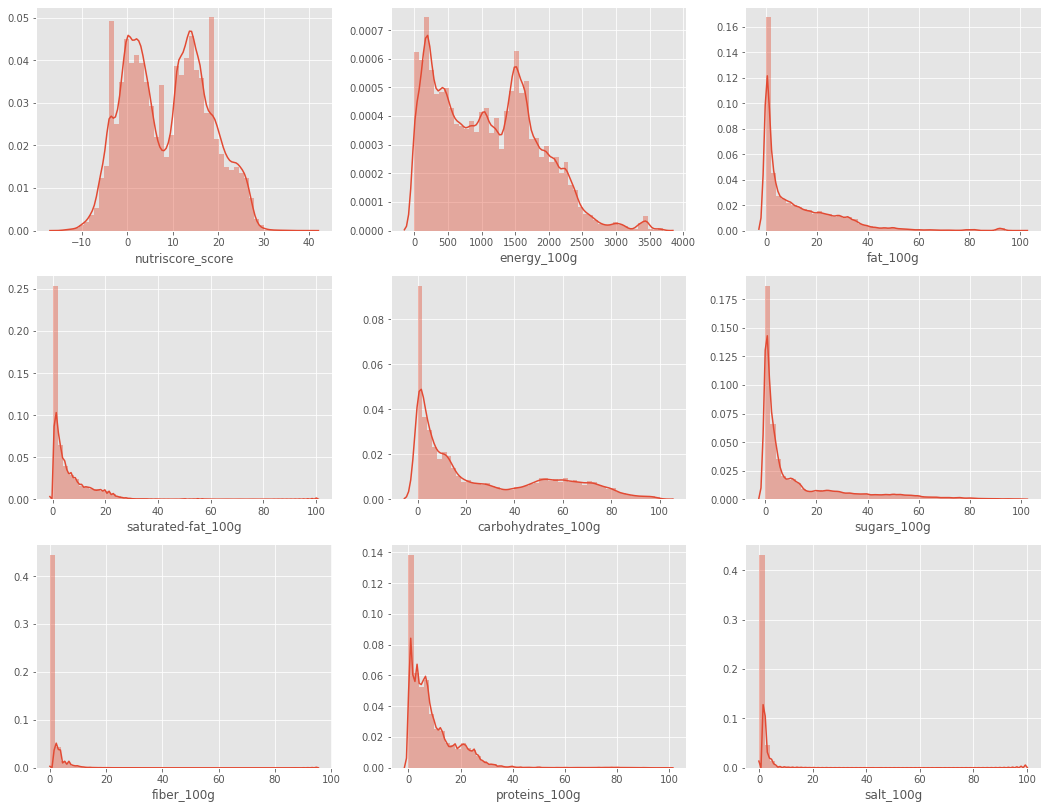

In [71]:


def plot_multiple_histograms(df, cols):
    matplotlib.rcParams['figure.figsize'] = (18,14)
    num_plots = len(cols)
    num_cols = math.ceil(np.sqrt(num_plots))
    num_rows = math.ceil(num_plots/num_cols)
        
    fig, axs = plt.subplots(num_rows, num_cols)
    
    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols
            
        if num_rows == 1:
            if num_cols == 1:
                sns.distplot(df[col], kde=True, ax=axs)
            else:
                sns.distplot(df[col], kde=True, ax=axs[j])
        else:
            sns.distplot(df[col], kde=True, ax=axs[i, j])

            
plot_multiple_histograms(df, ['nutriscore_score', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g'])

matplotlib.rcParams["figure.figsize"] = [6.4, 4.8]


### 2.2 Univariate Analysis: Categorical Variables


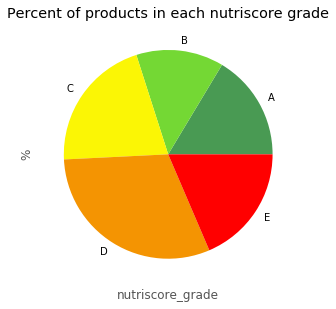

In [128]:
macro_nutriments_labels = []
for col in df :
    if "_100g" in col :
        macro_nutriments_labels.append(col)

colors = ["#499A53", "#74D834", "#FBF605", "#F49402", "#FF0000"]
labels = ["A", "B", "C", "D", "E"]
df['nutriscore_grade'].dropna().value_counts(normalize=True).sort_index().plot(kind='pie', colors=colors, labels=labels)
plt.title("Percent of products in each nutriscore grade")
plt.ylabel("%")
plt.xlabel("nutriscore_grade")
plt.xticks(rotation=0)
plt.style.use('ggplot')
plt.show()

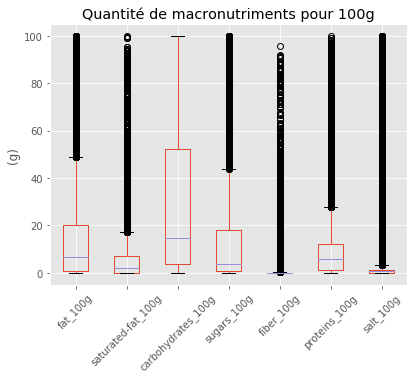

In [15]:
df[macro_nutriments_labels].drop(columns="energy_100g").boxplot()
plt.xticks(rotation=45)
plt.ylabel("(g)")
plt.title("Quantité de macronutriments pour 100g")
plt.style.use('ggplot')
plt.show()

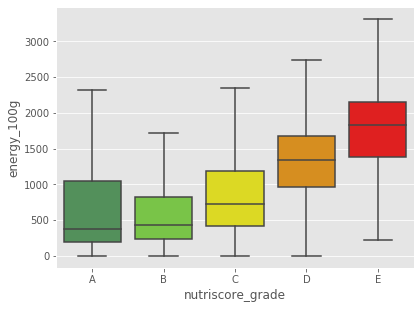

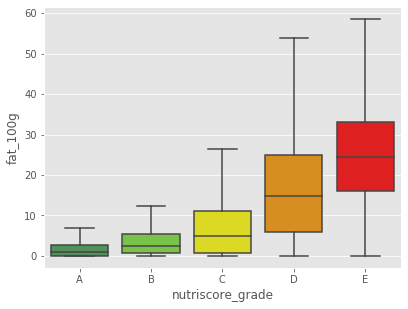

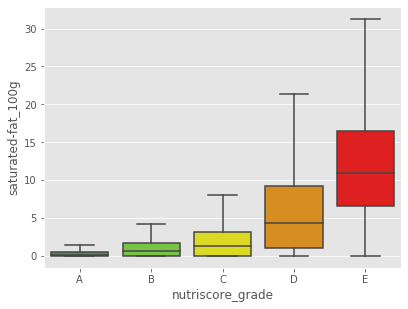

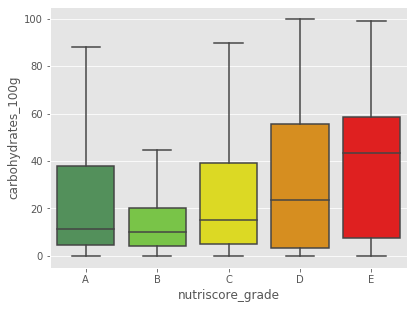

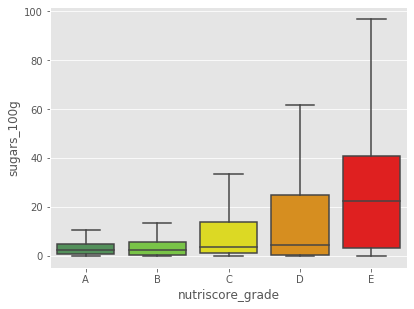

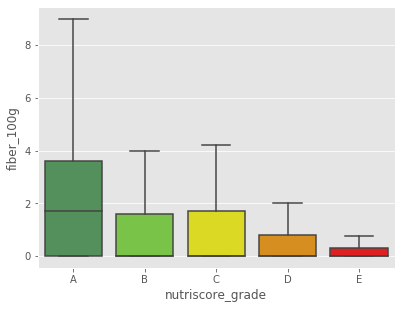

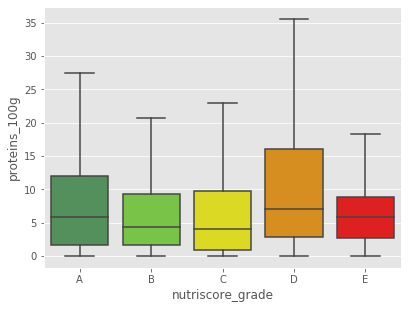

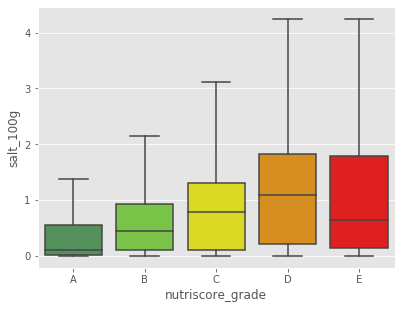

In [16]:
data_for_plot = df[macro_nutriments_labels + ["nutriscore_grade"]].dropna(subset=["nutriscore_grade"])
order = sorted(df["nutriscore_grade"].dropna().unique())
labels = ['A', 'B', 'C', 'D', 'E']
y_pos = np.arange(len(labels))
for macro_nutri in macro_nutriments_labels :
    sns.boxplot(data=data_for_plot, x='nutriscore_grade', y=macro_nutri, order=order, showfliers=False, palette={'a':"#499A53", 'b':"#74D834", 'c':"#FBF605", 'd':"#F49402", 'e':"#FF0000"})
    plt.xticks(y_pos, labels)
    plt.show()


- The more sugar, fat and salt in a product, the worse its Nutri-Score is.
- The higher the fibre content of a food, the lower the likelihood of poor nutritional quality.

### 2.3 Statistical Test : ANOVA Test 

##### Question
Is there a significant difference in protein value between the different grades of nutriscore?

##### Hypothesis formulation
H0 = There is equality between the nutriscore grades.
H1 = At least 1 grade is significantly different.

##### Choice of test
We have a quantitative variable and a qualitative variable with 5 modalities. We realize an anova.

In [119]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
data_lm = df[["nutriscore_grade", "proteins_100g"]].dropna(subset = ["nutriscore_grade"])
lm = ols('proteins_100g ~ C(nutriscore_grade)',data=data_lm).fit()
table = sm.stats.anova_lm(lm)
print(table)

                           df        sum_sq        mean_sq            F  \
C(nutriscore_grade)       4.0  9.898353e+05  247458.823274  3410.399548   
Residual             536473.0  3.892652e+07      72.560068          NaN   

                     PR(>F)  
C(nutriscore_grade)     0.0  
Residual                NaN  


As the p-value is below 0.05, we reject the null hypothesis in favor of the alternative: this means that at least one group mean is significantly different.

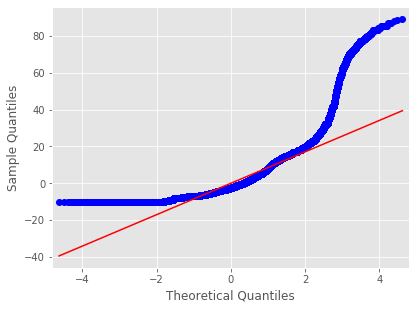

In [117]:
res = lm.resid 
fig = sm.qqplot(res, line='s')
plt.show()

### 2.3 Correlation

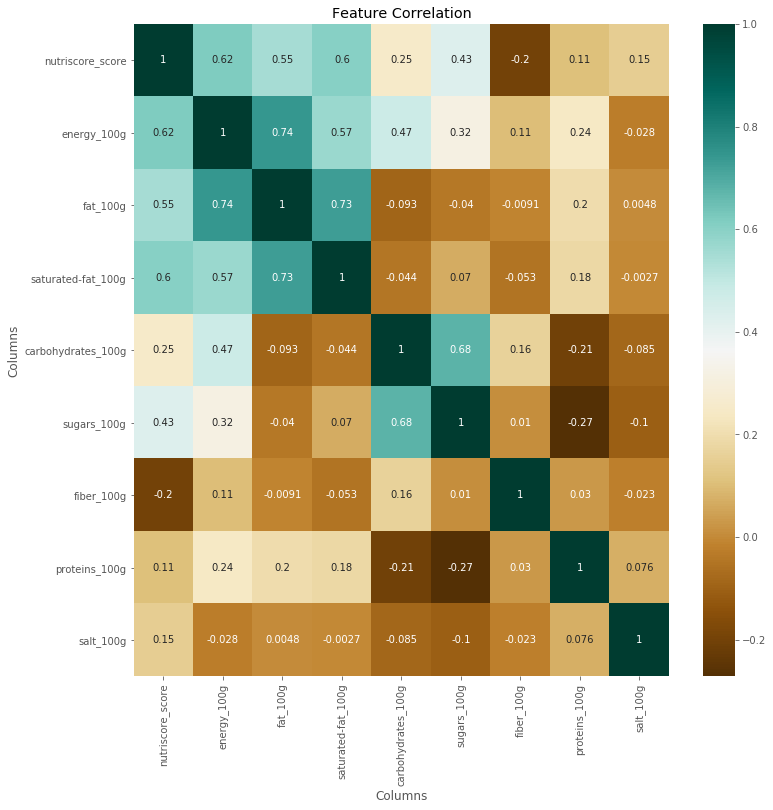

In [17]:
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(df.corr(), annot=True, ax=ax, cmap='BrBG').set(
    title = 'Feature Correlation', xlabel = 'Columns', ylabel = 'Columns')
plt.show()

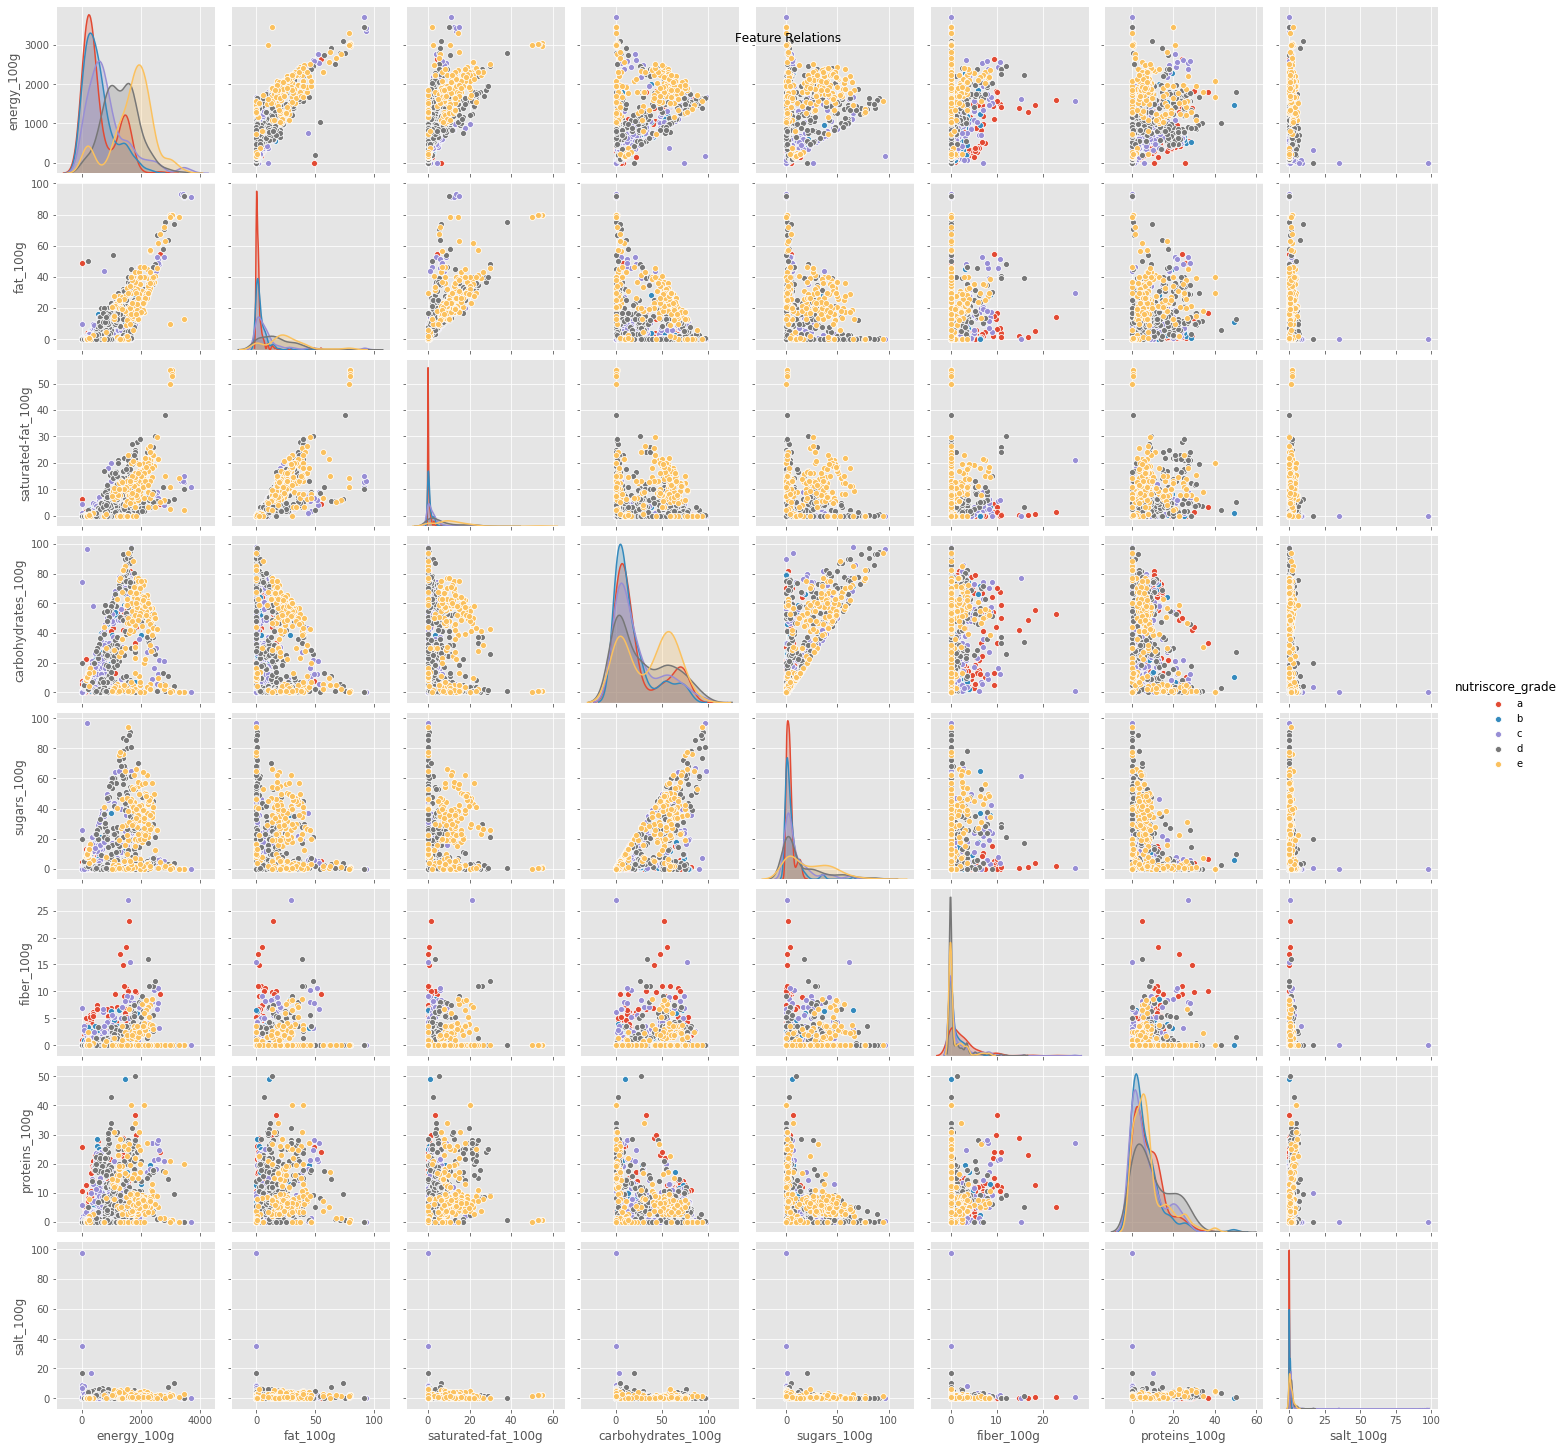

In [18]:
index = np.random.permutation(df.index)[0:2000]

g = sns.pairplot(data=df.loc[index], vars=["energy_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g", "sugars_100g" ,"fiber_100g", "proteins_100g", "salt_100g"], hue = "nutriscore_grade")
g.fig.suptitle('Feature Relations')
plt.show()

## 3. Data Pre-Conditioning¶

In this section we will make our data ready for model training. This will include:

1. Transform 'nutriscore_grade' column into numerical values.
2. Split data set into training and testing parts (80/20), while dropping the category column (string, and not going to be used to train the models), and separating nutriscore_grade column, where it will be used as labels.
3. We will try different splits of our dataset with/without feature scaling.

##### nutriscore_grade Transform


In [74]:
df_final = df[["product_name", "nutriscore_grade", "energy_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g", "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g"]]

##### Data Split 1: all of our final dataset, no scaling

In [75]:
y = df_final['nutriscore_grade'].dropna()
X = df_final.dropna(subset = ["nutriscore_grade"]).drop(['nutriscore_grade','product_name'], axis=1)

encoder = LabelEncoder()
y = encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

##### Data Split 2: all of our final dataset,  scaling

In [76]:
sc_X = StandardScaler()

X2_train = sc_X.fit_transform(X_train)
X2_test = sc_X.fit_transform(X_test)
y2_train = y_train
y2_test = y_test

## 4. Modelization
### 4.1 Cross Val Accuracy
##### K-NN

In [121]:
accuracy = {}

In [122]:
knn_clf = KNeighborsClassifier()

accuracy["knn"] = cross_val_score(knn_clf, X_train, y_train, cv=10)

print("Accuracy for a k-NN on validation dataset : {:.2f} %".format(100*accuracy["knn"].mean()))

Accuracy for a k-NN on validation dataset : 76.56 %


In [123]:
knn_clf2 = KNeighborsClassifier()

accuracy["knn2"] = cross_val_score(knn_clf2, X2_train, y2_train, cv=10)

print("Accuracy for a k-NN on validation dataset : {:.2f} %".format(100*accuracy["knn2"].mean()))

Accuracy for a k-NN on validation dataset : 86.91 %


##### Random Forest


In [124]:
forest_clf = RandomForestClassifier(n_estimators=30, random_state=101)

accuracy["random_forest"] = cross_val_score(forest_clf, X_train, y_train, cv=10)

print("Accuracy for a Random Forest Algorithm on validation dataset : {:.2f} %".format(100*accuracy["random_forest"].mean()))

Accuracy for a Random Forest Algorithm on validation dataset : 92.03 %


In [125]:
forest_clf2 = RandomForestClassifier(n_estimators=30, random_state=101)

accuracy["random_forest2"] = cross_val_score(forest_clf2, X2_train, y2_train, cv=10)

print("Accuracy for a Random Forest Algorithm on validation dataset : {:.2f} %".format(100*accuracy["random_forest2"].mean()))

Accuracy for a Random Forest Algorithm on validation dataset : 92.04 %


##### Model Selection

In [126]:
print("The performance of the k-nn model is around : {:.2f} % +- {:.2f} %".format(100*accuracy["knn2"].mean(), 100*accuracy["knn2"].std()))
print("The performance of the Random Forest model is around : {:.2f} % +- {:.2f} %".format(100*accuracy["random_forest"].mean(), 100*accuracy["random_forest"].std()))

The performance of the k-nn model is around : 86.91 % +- 0.21 %
The performance of the Random Forest model is around : 92.03 % +- 0.12 %


### 4.2 Random Forest
##### Modelization

In [28]:
rf1 = RandomForestClassifier(random_state=101, n_estimators=30)
rf1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False)

##### Prediction

In [29]:
rf1_pred = rf1.predict(X_test)

##### Evaluation

In [30]:
print('Random Forest Performance:')
print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(y_test, rf1_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf1_pred)))
print('R2_Score: ', metrics.r2_score(y_test, rf1_pred))

Random Forest Performance:

all features, No scaling:
MAE: 0.10696577691619445
RMSE: 0.4368804462396905
R2_Score:  0.8937598942800116


##### Optimization
We will use grid search in order to obtain good parameters for our RF regressor. Of course our optimization here will be limited due to time and computing power constraints. The parameters we will optimiz are:

- n-estimators
- min_samples_leaf
- max_features
- bootstrap

In [78]:
rf_param_grid = {'max_features': ['sqrt', 'auto'],
              'min_samples_leaf': [1, 3, 5],
              'n_estimators': [30, 50, 100],
             'bootstrap': [False, True]}

In [79]:
rf_grid = GridSearchCV(estimator= RandomForestClassifier(), param_grid = rf_param_grid,  n_jobs=-1, verbose=0)

In [80]:
rf_grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [81]:
rf_grid.best_params_

{'bootstrap': False,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'n_estimators': 100}

In [82]:
rf_opti = rf_grid.best_estimator_
rf_opti

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [83]:
rf_grid_predictions = rf_grid.predict(X_test)

In [84]:
print('MAE:', metrics.mean_absolute_error(y_test, rf_grid_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf_grid_predictions)))
print('R2_Score: ', metrics.r2_score(y_test, rf_grid_predictions))

MAE: 0.10244557113033105
RMSE: 0.43031383549404517
R2_Score:  0.8969296147055652


In [38]:
#rf_grid.fit(X, y)

#Test du Khi2 d'adequation

### 4.3 Error Analysis
##### Confusion Matrix

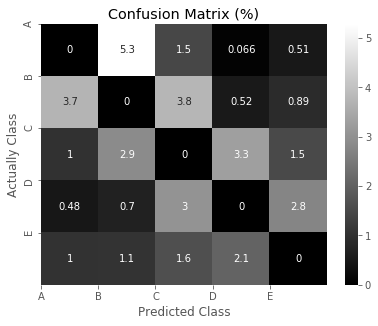

In [127]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_test, rf_grid_predictions)

row_sums = conf_mx.sum(axis=0, keepdims=True)
norm_conf_mx = conf_mx / row_sums *100

# On remplace les valeurs de la diagonale par des 0
np.fill_diagonal(norm_conf_mx, 0)

sns.heatmap(norm_conf_mx, cmap=plt.cm.gray, annot=True)
plt.title("Confusion Matrix (%)")
plt.xlabel("Predicted Class")
plt.ylabel("Actually Class")
plt.xticks(np.arange(5), ('A', 'B', 'C', 'D', 'E'))
plt.yticks(np.arange(5), ('A', 'B', 'C', 'D', 'E'))

plt.show()

In [88]:

print("The precision score is : \n \
      - Class A : {:.2f} %\n \
      - Class B : {:.2f} %\n \
      - Class C : {:.2f} %\n \
      - Class D : {:.2f} %\n \
      - Class E : {:.2f} %\n".format(conf_mx[0,0]/conf_mx.sum(axis=0)[0]*100,
                                      conf_mx[1,1]/conf_mx.sum(axis=0)[1]*100,
                                      conf_mx[2,2]/conf_mx.sum(axis=0)[2]*100,
                                      conf_mx[3,3]/conf_mx.sum(axis=0)[3]*100,
                                      conf_mx[4,4]/conf_mx.sum(axis=0)[4]*100,
                                   ))

print("Among the products predicted in class A, only {:.2f} % are actually in class A \n \
{:.2f} % are from class B, {:.2f} % are from class C, {:.2f} % are from class D and {:.2f} % are from class E \n".format(conf_mx[0,0]/conf_mx.sum(axis=0)[0]*100,
                                                                                                                      conf_mx[1,0]/conf_mx.sum(axis=0)[0]*100,
                                                                                                                      conf_mx[2,0]/conf_mx.sum(axis=0)[0]*100,
                                                                                                                      conf_mx[3,0]/conf_mx.sum(axis=0)[0]*100,
                                                                                                                      conf_mx[4,0]/conf_mx.sum(axis=0)[0]*100))
     

print("Among the products actually in class A, only {:.2f} % are actually in class A \n \
{:.2f} % are from class B, {:.2f} % are from class C, {:.2f} % are from class D and {:.2f} % are from class E".format(conf_mx[0,0]/conf_mx.sum(axis=0)[0]*100,
                                                                                                                      conf_mx[0,1]/conf_mx.sum(axis=0)[0]*100,
                                                                                                                      conf_mx[0,2]/conf_mx.sum(axis=0)[0]*100,
                                                                                                                      conf_mx[0,3]/conf_mx.sum(axis=0)[0]*100,
                                                                                                                      conf_mx[0,4]/conf_mx.sum(axis=0)[0]*100))

The precision score is : 
       - Class A : 93.73 %
       - Class B : 90.08 %
       - Class C : 90.09 %
       - Class D : 94.06 %
       - Class E : 94.32 %

Among the products predicted in class A, only 93.73 % are actually in class A 
 3.74 % are from class B, 1.01 % are from class C, 0.48 % are from class D and 1.04 % are from class E 

Among the products actually in class A, only 93.73 % are actually in class A 
 4.20 % are from class B, 1.88 % are from class C, 0.12 % are from class D and 0.57 % are from class E


##### Model/Reality Gap

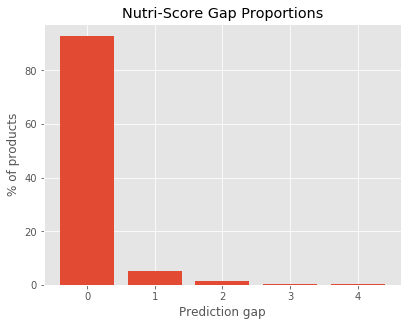

In [89]:
ecart = [list(abs(y_test - rf_grid_predictions)).count(k)/len(y_test)*100 for k in range(5)]
plt.bar(height = ecart, x =range(5))
plt.xlabel("Prediction gap")
plt.ylabel("% of products")
plt.title("Nutri-Score Gap Proportions")
plt.show()

##### Prediction exemple

In [90]:
X_na = df_final[df_final.nutriscore_grade.isna()].drop(['nutriscore_grade','product_name'], axis=1)
y_na = rf_opti.predict(X_na)
y_na = encoder.inverse_transform(y_na)

In [91]:
df_final["nutriscore_grade"][df_final["nutriscore_grade"].isna()] = y_na

##### Proportion of nutriscore in dataset products before and after predicton

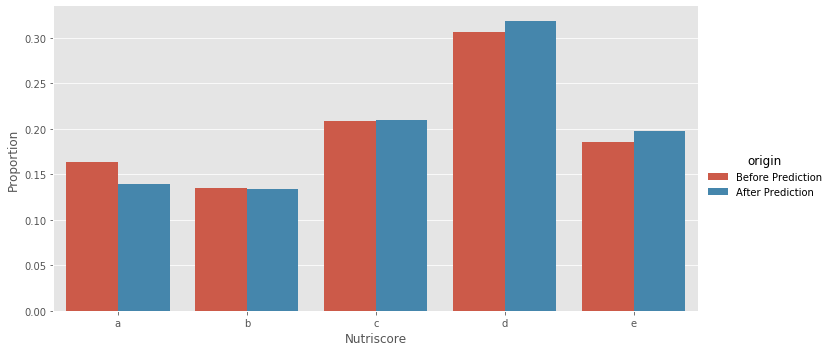

In [112]:
df_before_prediction = df["nutriscore_grade"].value_counts(normalize=True).rename_axis('Nutriscore').reset_index(name='Proportion')
df_before_prediction["origin"]="Before Prediction"
df_after_prediction = df_final["nutriscore_grade"].value_counts(normalize=True).rename_axis('Nutriscore').reset_index(name='Proportion')
df_after_prediction["origin"]="After Prediction"

df_comparison = pd.concat([df_before_prediction, df_after_prediction], axis=0, ignore_index=False)
df_comparison.reset_index(inplace=True)

sns.catplot(x='Nutriscore', y='Proportion', hue='origin', kind='bar', data=df_comparison, height=5, aspect=2) 

##### Proportion of nutriscore in dataset products after predicton

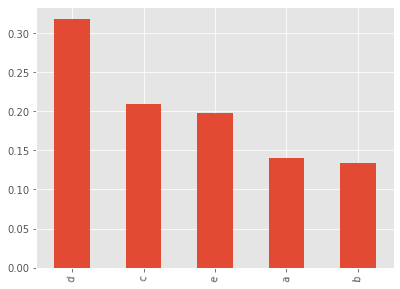

In [48]:
df_final["nutriscore_grade"].value_counts(normalize=True).plot(kind='bar')
plt.xticks(rotation=85)
plt.show()

### 4.4 Features Importance

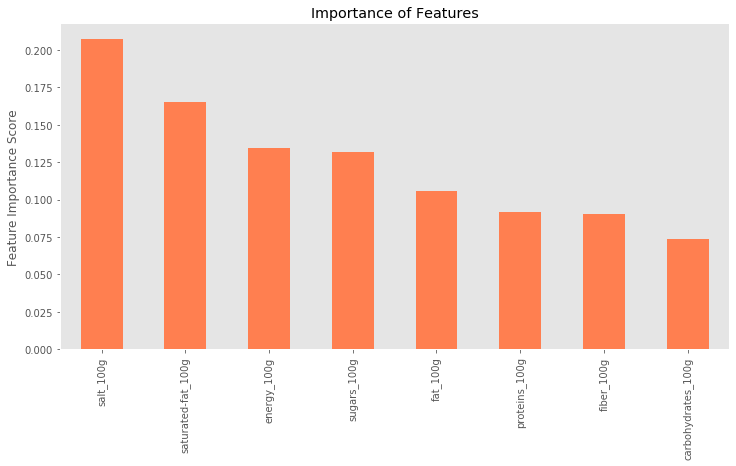

In [39]:
feat_imp = pd.Series(rf_grid.best_estimator_.feature_importances_, list(X_train)).sort_values(ascending=False)
fig = plt.figure(figsize=(12, 6))
feat_imp.plot(kind='bar', title='Importance of Features', color= 'coral')
plt.ylabel('Feature Importance Score')
plt.grid()
plt.show()

## 5. Conclusion

In this project, we used the Open Food Fact dataset to build a nutriscore grade predictor. 2 different learning classifier (K-NN and Random Forest) were tested, and we have acheived the best prediction performance using Random Forest.

The best prediction performance was acheived using Random Forest regressor, using all features in the dataset and without scaling, and resulted in the following metrics:

- Mean Absolute Error (MAE): 0.1018677303906949
- Root mean squared error (RMSE): 0.4292078235549481
- R-squared Score (R2_Score):  0.8974587660695692